In [1]:
#@title Connect to Drive
# Import project and set a symbolic link in /content

import os
from google.colab import drive
drive.mount('/content/gdrive')

# set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/bayesian-privacy'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/bayesian-privacy'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

## Move in the project directory
%cd /content/bayesian-privacy
!pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/bayesian-privacy
/content/gdrive/My Drive/bayesian-privacy


In [2]:
#@title All imports
#%reload_ext autoreload
#%autoreload 2

import argparse
import itertools
import numpy as np
import pandas as pd
import os
import pickle
import random
import time
from tqdm import tqdm
import gc

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision.datasets import CIFAR10, CIFAR100
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_

from torch.optim.optimizer import required
from torch.autograd import Variable, Function

from scipy.spatial.distance import pdist
from scipy.stats import ttest_rel, ttest_ind, levene

import random
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)

from bayesian_privacy_accountant import BayesianPrivacyAccountant

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda:0


In [3]:
dataroot = 'data'
output_folder = 'output'

try:
    os.makedirs(output_folder)
except OSError:
    pass

# For .py
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=32, help='input batch size')
parser.add_argument('--image_size', type=int, default=32, help='the height / width of the input image to network')
parser.add_argument('--channels', type=int, default=3, help='number of colour channels')
parser.add_argument('--filters', type=int, default=64)
parser.add_argument('--kernel_size', type=int, default=5)
parser.add_argument('--epochs', type=int, default=10, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate, default=0.0002')
parser.add_argument('--C', type=float, default=1.0, help='embedding L2-norm bound, default=1.0')
parser.add_argument('--sigma', type=float, default=0.8, help='noise variance, default=0.5')
parser.add_argument('--cifar_type', type=int, default=2, help='number of labels (classes)')

_StoreAction(option_strings=['--cifar_type'], dest='cifar_type', nargs=None, const=None, default=2, type=<class 'int'>, choices=None, required=False, help='number of labels (classes)', metavar=None)

In [4]:
# @title Load Datasets
classes = {'plane':0, 'car':1, 'bird':2, 'cat':3,
           'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

class CIFARN(CIFAR10):
    def __init__(self, root, labels, train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)
        self.targets = np.array(self.targets)
        self.data = np.array(self.data)
        classes2keep = np.sum([self.targets==classes[label] for label in labels], axis=0).astype(bool)
        self.data = self.data[classes2keep]
        self.targets = self.targets[classes2keep]
        for new_label, label in enumerate(sorted(set(self.targets))):
            self.targets[self.targets==label] = new_label

# transformations applied to data
transform = transforms.Compose([transforms.Resize(size=(128, 128)),
                                transforms.RandomHorizontalFlip(), 
                                transforms.ColorJitter(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
transform_test = transforms.Compose([transforms.Resize(size=(128, 128)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [5]:
def compute_dim_out(num_conv_layers, dim_in, kernel_size=3, stride=1, padding=0, dilation=1):
    dim_out = dim_in
    for i in range(num_conv_layers):
        dim_out = int((dim_out + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1)//2
    return dim_out

compute_dim_out(num_conv_layers=3, dim_in=32, kernel_size=3, stride=1, padding=1, dilation=1)

4

In [6]:
#@title SimpleConvNet
def ConvLayerBlock(in_channels):
  return nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=in_channels*2, kernel_size=3, padding=1),
          nn.BatchNorm2d(in_channels*2),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=in_channels*2, out_channels=in_channels*2, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout2d(p=0.05),
  )

class SimpleConvNet(nn.Module):
   
    def __init__(self, opt, channels=3, filters=32):
        
        super(SimpleConvNet, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=channels, out_channels=filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=filters, out_channels=filters*2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            ConvLayerBlock(in_channels=filters*2),
            ConvLayerBlock(in_channels=filters*4),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, opt.cifar_type)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

In [7]:
def test(testloader, net):
    """
        Compute test accuracy.
    """
    correct = 0.0
    total = 0.0

    for data in testloader:
        images, labels = data
    
        images = images.to(device)
        labels = labels.to(device)
            
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == (labels.long().view(-1) % 100)).sum()

    return 100 * float(correct) / total

In [8]:
def sparsify_update(params, p, use_grad_field=True):
    init = True
    for param in params:
        if param is not None:
            if init:
                idx = torch.zeros_like(param, dtype=torch.bool)
                idx.bernoulli_(1 - p)
            if use_grad_field:
                if param.grad is not None:
                    idx = torch.zeros_like(param, dtype=torch.bool)
                    idx.bernoulli_(1 - p)
                    param.grad.data[idx] = 0
            else:
                init = False
                param.data[idx] = 0
    return idx

In [9]:
#@title Train Baseline
def train_bl(trainloader, testloader, student, opt):
    student.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=opt.lr)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
    #                                          T_max=opt.epochs*len(trainloader))
                       
    student = student.to(device)
    criterion = criterion.to(device)
    
    acc = 0
    
    with tqdm(range(opt.epochs)) as t:
      for epoch in t:
        gc.collect()
        torch.cuda.empty_cache()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            # get the inputs
            inputs = inputs.to(device)
            labels = labels.to(device)

            batch_size = float(len(inputs))
                        
            optimizer.zero_grad()
            
            outputs = student(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            running_loss += loss.item()

            optimizer.step()
            #scheduler.step()

            t.set_postfix(loss=loss.item(),
                          Acc=acc,
                          #lr=scheduler.get_last_lr(),
                          )

        student.eval()
        with torch.no_grad():
            acc = test(testloader, student)
        student.train()

        if (epoch + 1) % max(opt.epochs//100, 1) == 0:
            torch.save(student.state_dict(), '%s/baseline_net_epoch_%d.pth' % (output_folder, epoch + 1))

    print(f'Final accuracy : {acc}')
    student.acc = acc
    return student.cpu()

In [10]:
#@title Train simple dp (without compute ($\epsilon$-$\delta$)-DP)

def train_simple_dp(trainloader, testloader, student, opt, accountant=None):

    student.train()
    criterion = nn.CrossEntropyLoss(reduction='none')
    optimizer = optim.Adam(student.parameters(), lr=opt.lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                              T_max=opt.epochs*len(trainloader))
                                               
    student = student.to(device)
    criterion = criterion.to(device)
    
    acc = 0
    
    with tqdm(range(opt.epochs)) as t:
      for epoch in t:
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):

            gc.collect()
            torch.cuda.empty_cache()

            batch_size = len(inputs)
            grads_est = []

            for param in [p for p in student.parameters() if p.requires_grad]:
                param.accumulated_grads = torch.zeros_like(param)
            
            # Run the microbatches
            for x, y in zip(inputs, labels):
                x = x.to(device)[None,...]
                y = y.to(device)[None,...]
                y_hat = student(x)
                loss = criterion(y_hat, y)
                loss.backward()
            
                # Clip each parameter's per-sample gradient

                for param in [p for p in student.parameters() if p.requires_grad]:
                    per_sample_grad = param.grad.detach().clone()
                    clip_grad_norm_(per_sample_grad, max_norm=opt.C)  # in-place
                    param.accumulated_grads += per_sample_grad

                    with torch.no_grad():
                        per_sample_grad = torch.cat([g.view(-1) for g in per_sample_grad])
                        grads_est += [per_sample_grad]
                
            # Now we are ready to update and add noise!
            with torch.no_grad():
                for param in [p for p in student.parameters() if p.requires_grad]:

                    param -= opt.lr * param.accumulated_grads
                    param += torch.normal(mean=torch.Tensor(0), std=torch.Tensor(opt.sigma * opt.C)**2)/batch_size
                    
                grad_pairs = list(zip(*itertools.combinations(grads_est, 2)))
                accountant.accumulate(
                    ldistr=(torch.stack(grad_pairs[0]), (opt.sigma*opt.C)),
                    rdistr=(torch.stack(grad_pairs[1]), (opt.sigma*opt.C)),
                    q=float(batch_size) / len(trainloader.dataset), 
                    steps=1,
                )

            for param in [p for p in student.parameters() if p.requires_grad]:
                param.grad = 0  # Reset for next iteration

            t.set_postfix(loss=loss.item(),
              Acc=acc,
              #lr=scheduler.get_last_lr(),
              )
            
        student.eval()
        with torch.no_grad():
            acc = test(testloader, student)
        student.train()

    print(f'Final accuracy : {acc}')
    eps, delta  = accountant.get_privacy(target_delta=opt.delta)
    print("Epsilon = ", accountant.get_privacy(target_delta=opt.delta))
    return student.cpu()


            # Aggregate back
            #for param in student.parameters():
            #    param.grad = torch.stack(param.accumulated_grads, dim=0)

            # Now we are ready to update and add noise!
            #for param in student.parameters():
            #    param = param - opt.lr * param.grad
            #    param += torch.normal(mean=0, std=(opt.noise_multiplier * opt.max_grad_norm)**2)
                
            #    param.grad = 0  # Reset for next iteration

'\n            # Aggregate back\n            for param in student.parameters():\n                param.grad = torch.stack(param.accumulated_grads, dim=0)\n\n            # Now we are ready to update and add noise!\n            for param in student.parameters():\n                param = param - opt.lr * param.grad\n                param += torch.normal(mean=0, std=(opt.noise_multiplier * opt.max_grad_norm)**2)\n                \n                param.grad = 0  # Reset for next iteration\n'

In [11]:
#@title Train DP
def train_dp(trainloader, testloader, student, opt, eps, accountant='prv'):
    student = ModuleValidator.fix(student)

    privacy_engine = PrivacyEngine(accountant = accountant)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=opt.lr)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
    #                                          T_max=opt.epochs*len(trainloader))
    
    student, optimizer, trainloader = privacy_engine.make_private_with_epsilon(
        module=student,
        optimizer=optimizer,
        data_loader=trainloader,
        epochs=opt.epochs,
        target_epsilon=eps,
        target_delta=opt.delta,
        max_grad_norm=opt.C,
    )

    student.train()
                                               
    student = student.to(device)
    criterion = criterion.to(device)
    
    acc = 0

    with tqdm(range(opt.epochs)) as t:
      for epoch in t:
        running_loss = 0.0

        gc.collect()
        torch.cuda.empty_cache()
          
        with BatchMemoryManager(
            data_loader=trainloader, 
            max_physical_batch_size=64,#opt.batch_size, 
            optimizer=optimizer
        ) as memory_safe_data_loader:
            for i, (inputs, labels) in enumerate(memory_safe_data_loader):

                # get the inputs
                inputs = inputs.to(device)
                labels = labels.to(device)
                            
                optimizer.zero_grad()
                
                outputs = student(inputs)
                loss = criterion(outputs, labels)
                
                loss.backward()
                running_loss += loss.item()

                optimizer.step()
                #scheduler.step()

                t.set_postfix(loss=loss.item(),
                              Acc=acc,
                              #lr=scheduler.get_last_lr(),
                              )

            student.eval()
            with torch.no_grad():
                acc = test(testloader, student)
            student.train()

            if (epoch + 1) % max(opt.epochs//100, 1) == 0:
                torch.save(student.state_dict(), '%s/dp_net_epoch_%d.pth' % (output_folder, epoch + 1))

    print(f'Final accuracy : {acc}', '(𝜀,𝛿)', privacy_engine.get_epsilon(opt.delta), opt.delta)
    return student.cpu()

In [12]:
#@title Train BayesianDP

def train_bdp(trainloader, testloader, student, opt, accountant=None):
  
    criterion = nn.CrossEntropyLoss(reduction='none')
    optimizer = optim.Adam(student.parameters(), lr=opt.lr)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
    #                                          T_max=opt.epochs*len(trainloader))
                                               
    student = student.to(device)
    criterion = criterion.to(device)
    
    acc = 0
    
    sampling_prob = 1.0
    
    #sigma = opt.sigma *  opt.C # ?
    
    with tqdm(range(opt.epochs)) as t:
      for epoch in t:
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            gc.collect()
            torch.cuda.empty_cache()

            inputs = inputs.to(device)
            labels = labels.to(device)

            batch_size = len(inputs)
                        
            optimizer.zero_grad()
            
            outputs = student(inputs)
            loss = criterion(outputs, labels)
            
            grads_est = []
            for j in range(opt.subbatch):
                #grad_sample = torch.autograd.grad(np.delete(loss, j).mean(), [p for p in student.parameters() if p.requires_grad], retain_graph=True)
                grad_sample = torch.autograd.grad(loss[np.delete(range(int(batch_size)), j)].mean(), [p for p in student.parameters() if p.requires_grad], retain_graph=True)
                with torch.no_grad():
                    grad_sample = torch.cat([g.view(-1) for g in grad_sample])
                    #grad_sample /= max(1.0, grad_sample.norm().item() / C)
                    grads_est += [grad_sample]
            with torch.no_grad():
                sparsify_update(grads_est, p=sampling_prob, use_grad_field=False)
                    
            (loss.mean()).backward()
            running_loss += loss.mean().item()
            
            #torch.nn.utils.clip_grad_norm_(student.parameters(), C)
            for group in optimizer.param_groups:
                for p in group['params']:
                    if p.grad is not None:
                        p.grad.data += torch.randn_like(p.grad) * (opt.sigma * opt.C)
#                        p.grad.data += torch.randn_like(p.grad) * (opt.sigma * opt.C)**2
            sparsify_update(student.parameters(), p=sampling_prob)
            
            optimizer.step()
            #scheduler.step()

            with torch.no_grad():
                # NOTE: 
                # Using combinations within a set of gradients (like below)
                # does not actually produce samples from the correct distribution
                # (for that, we need to sample pairs of gradients independently).
                # However, the difference is not significant, and it speeds up computations.
                grad_pairs = list(zip(*itertools.combinations(grads_est, 2)))
                accountant.accumulate(
                    ldistr=(torch.stack(grad_pairs[0]), (opt.sigma*opt.C)),
                    rdistr=(torch.stack(grad_pairs[1]), (opt.sigma*opt.C)),
                    q=float(batch_size) / len(trainloader.dataset), 
                    steps=1,
                )

            t.set_postfix(loss=loss.mean().item(),
                          Acc=acc, p={'(𝜀,𝛿)':accountant.get_privacy(target_delta=opt.delta)},
                          #lr=scheduler.get_last_lr(),
                          )

        student.eval()
        with torch.no_grad():
            acc = test(testloader, student)
        student.train()

        if (epoch + 1) % max(opt.epochs//100, 1) == 0:
            torch.save(student.state_dict(), '%s/bdp_net_epoch_%d.pth' % (output_folder, epoch + 1))
            pickle.dump(accountant, open('%s/bayes_accountant_epoch_%d' % (output_folder, epoch + 1), 'wb'))

    print(f'Final accuracy : {acc}')
    eps, delta  = accountant.get_privacy(target_delta=1e-10)
    print("Epsilon = ", accountant.get_privacy(target_delta=delta))
    student.acc = acc
    student.eps = eps
    student.sigma = opt.sigma
    return student.cpu()

In [13]:
def netChoice(opt, last_conv_grad=True):
    if opt.load_vgg16:
        netS = torchvision.models.vgg16(weights='DEFAULT')
        netS.train()
        # Disable updates for feature extraction layers
        for p in netS.named_parameters():
            p[1].requires_grad = False
        if last_conv_grad:
          for l in [p for p in netS.features.parameters()][-3:]:
            l.requires_grad = True
          netS.avgpool.requires_grad = True
        for l in netS.classifier:
          l.requires_grad = True
        netS.classifier[-1] = nn.Linear(4096, opt.cifar_type)
        netS.aux_logits = False
        return netS

    else:  
        return SimpleConvNet(opt)

In [14]:
def load_set(opt):
    if opt.cifar_type == '100':
        trainset = CIFAR100(root=dataroot + '/cifar10', train=True, download=True, transform=transform)
        testset = CIFAR100(root=dataroot + '/cifar10', train=False, download=True, transform=transform_test)
        opt.cifar_type = 100
    else:
        if opt.cifar_type == '10':
            labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        elif opt.cifar_type == '2_dif':
            labels = ['car', 'cat']
        elif opt.cifar_type == '2_sim':
            labels = ['car', 'truck']

        #labels = ['bird', 'cat', 'deer', 'dog', 'frog', 'horse'] # animals
        #labels = ['plane', 'car', 'ship', 'truck']               # vehicules

        opt.cifar_type = len(labels)
        trainset = CIFARN(root=dataroot + '/cifar10', labels=labels, train=True, download=True, transform=transform)
        testset = CIFARN(root=dataroot + '/cifar10', labels=labels,  train=False, download=True, transform=transform_test)

    return trainset, testset

In [15]:
class Config:
    def __init__(self):
        # Training
        self.batch_size = 512
        self.epochs = 2
        self.lr = .001

        # BDP
        self.C = 1
        self.sigma = 1
        self.power = [2,4,8,16,32,64]
        self.subbatch = 8

        self.delta = 1e-5

        # Dataset/model
        self.cifar_type = '2_sim' #['2_sim', '2_dif', '10', '100'] 
        self.load_vgg16 = True

gc.collect()
torch.cuda.empty_cache()

opt = Config()

# initialise data loaders
trainset, testset = load_set(opt)

trainloader = DataLoader(trainset, batch_size=opt.batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=opt.batch_size, shuffle=False, num_workers=2)
netS = {}

sigma_list = np.linspace(.3, 3, 10)
for sigma in sigma_list:
    opt.sigma = sigma
    bayes_accountant = BayesianPrivacyAccountant(powers=opt.power, total_steps=opt.epochs * len(trainloader))
    netS[f'bdp_{sigma}'] = train_bdp(trainloader, testloader, netChoice(opt), opt, accountant=bayes_accountant)

netS['bl'] = train_bl(trainloader, testloader, netChoice(opt), opt)

Files already downloaded and verified
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

100%|██████████| 2/2 [01:44<00:00, 52.50s/it, Acc=91, loss=0.276, p={'(𝜀,𝛿)': (3.06306640101851, 1e-05)}]


Final accuracy : 91.45
Epsilon =  (5.941308869626817, 1e-10)


100%|██████████| 2/2 [01:29<00:00, 44.52s/it, Acc=89.6, loss=0.278, p={'(𝜀,𝛿)': (0.8387922799953939, 1e-05)}]


Final accuracy : 90.9
Epsilon =  (1.5583528971474707, 1e-10)


100%|██████████| 2/2 [01:27<00:00, 43.58s/it, Acc=87.3, loss=0.351, p={'(𝜀,𝛿)': (0.5550594577809972, 1e-05)}]


Final accuracy : 89.15
Epsilon =  (0.9148397663570356, 1e-10)


100%|██████████| 2/2 [01:28<00:00, 44.49s/it, Acc=87.2, loss=0.331, p={'(𝜀,𝛿)': (0.27435958772111063, 1e-05)}]


Final accuracy : 88.95
Epsilon =  (0.4542497420091299, 1e-10)


100%|██████████| 2/2 [01:28<00:00, 44.08s/it, Acc=85.3, loss=0.418, p={'(𝜀,𝛿)': (0.24961264227254576, 1e-05)}]


Final accuracy : 88.85
Epsilon =  (0.429502796560565, 1e-10)


100%|██████████| 2/2 [01:28<00:00, 44.24s/it, Acc=80.7, loss=0.493, p={'(𝜀,𝛿)': (0.23161568866519466, 1e-05)}]


Final accuracy : 87.4
Epsilon =  (0.41150584295321385, 1e-10)


100%|██████████| 2/2 [01:28<00:00, 44.50s/it, Acc=79.8, loss=0.493, p={'(𝜀,𝛿)': (0.22048203245671188, 1e-05)}]


Final accuracy : 86.3
Epsilon =  (0.4003721867447311, 1e-10)


100%|██████████| 2/2 [01:29<00:00, 44.68s/it, Acc=80.2, loss=0.48, p={'(𝜀,𝛿)': (0.20608047537812943, 1e-05)}]


Final accuracy : 87.0
Epsilon =  (0.38597062966614865, 1e-10)


100%|██████████| 2/2 [01:32<00:00, 46.13s/it, Acc=80.5, loss=0.439, p={'(𝜀,𝛿)': (0.2018103468288579, 1e-05)}]


Final accuracy : 86.4
Epsilon =  (0.38170050111687714, 1e-10)


100%|██████████| 2/2 [01:31<00:00, 45.57s/it, Acc=78, loss=0.52, p={'(𝜀,𝛿)': (0.19956997667192888, 1e-05)}]


Final accuracy : 83.95
Epsilon =  (0.3794601309599481, 1e-10)


100%|██████████| 2/2 [01:02<00:00, 31.38s/it, Acc=94.5, loss=0.0644]


Final accuracy : 95.55


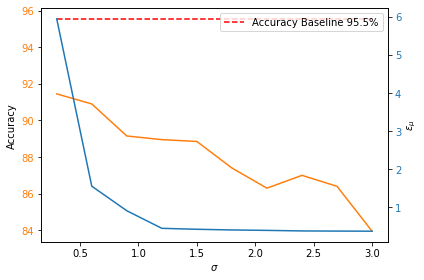

In [16]:
accuracies = []
sigmas = []
epsilons = []

for account, net in netS.items():
    if account!='bl':
      accuracies.append(net.acc)
      sigmas.append(net.sigma)
      epsilons.append(net.eps)


fig, ax1 = plt.subplots()

color = 'tab:orange'
ax1.set_xlabel(r'$\sigma$')
ax1.set_ylabel('Accuracy')
ax1.plot(sigmas, accuracies, color=color)
ax1.plot([sigmas[0], sigmas[-1]], [netS['bl'].acc, netS['bl'].acc], 'r--', label='Accuracy Baseline {:.1f}%'.format(netS["bl"].acc))
ax1.tick_params(axis='y', labelcolor=color)
plt.legend(loc='upper right')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'$\epsilon_{\mu}$')  # we already handled the x-label with ax1
ax2.plot(sigmas, epsilons, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#plt.yscale('log')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [42]:
labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#labels = ['car', 'cat']
#labels = ['car', 'truck']

class_definition = {i:labels[i] for i in range(len(labels))}
#class_definition = None

from matplotlib.colors import to_hex
import matplotlib

# definition of the scatterplot
def make_scatterplot(X, y, feature1=None, feature2=None, 
                     class_indices=None, class_definition=None, title=''):
    if class_indices is None:
        class_indices = np.unique(y)
    if class_definition is None:
        class_definition = dict(zip(class_indices, [str(i) for i in class_indices]))

    # colors
    colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]
    #colors = matplotlib.colormaps.get_cmap('tab10', 10).colors[:,:3]

    #plt.xlabel(feature1)
    #plt.ylabel(feature2)
    plt.title(title)
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        left=False,
        labelbottom=False, # labels along the bottom edge are off
        labelleft=False) # labels along the bottom edge are off

    comp1 = X[:,0]
    comp2 = X[:,1]
    for class_index in class_indices:
        class_label = class_definition[class_index]
        plt.scatter(comp1[y==class_index],
                   comp2[y==class_index],
                   c=to_hex(colors[class_index]),
                   label=class_label,
                   s=15)
    plt.legend()
    plt.grid()

OutOfMemoryError: ignored

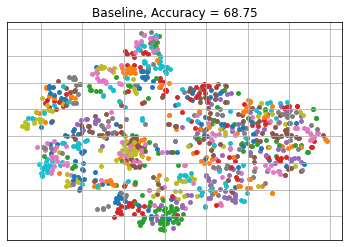

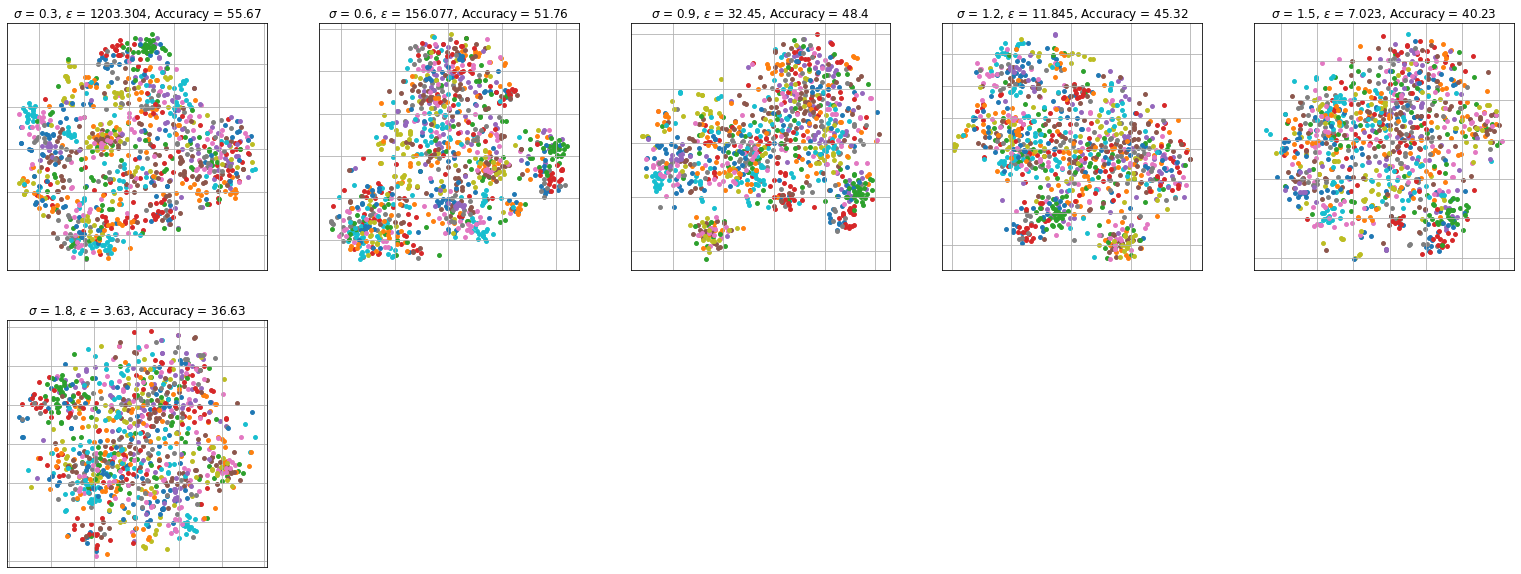

In [45]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA, SparsePCA
title = [f'$\sigma$ = {np.round(0.3*(i+1), 1)}, $\epsilon$ = {np.round(epsilons[i], 3)}, Accuracy = {accuracies[i]}' for i in range(10)]

gc.collect()
torch.cuda.empty_cache()

for i, (x, y) in enumerate(trainloader):

    netS['bl'] = netS['bl'].to(device)
    features = netS['bl'](x.to(device)).view(opt.batch_size, -1).cpu().detach().numpy()
    pca = TSNE(n_components=2)
    X_bl = pca.fit_transform(features)
    make_scatterplot(X_bl, y.flatten(), class_definition=class_definition, title=f"Baseline, Accuracy = {netS['bl'].acc}")

    plt.figure(figsize=(len(netS)*5//2, 10))
    for i, (account, net) in enumerate(netS.items()):
        if account!='bl':
            net = net.to(device)
            features = net(x.to(device)).view(opt.batch_size, -1).cpu().detach().numpy()
            X = pca.fit_transform(features)
            plt.subplot(2, len(netS)//2, i+1)
            make_scatterplot(X, y.flatten(), class_definition=class_definition, title=title[i])
    plt.show()
    break